# Cuaderno 03: Vía Auditiva - Emulación de la Conciencia Fonológica

### El "Porqué" Cognitivo: Deletrear para Imaginar el Sonido 🧠

Este cuaderno modela uno de los procesos cognitivos más abstractos y fascinantes del lenguaje: la **conciencia fonológica**. Específicamente, emulamos la habilidad de tomar una secuencia de **nombres de letras deletreadas** (escuchar "pe", "a", "pe", "a") y usarla para **"imaginar" o construir internamente** la representación neuronal del sonido de la palabra completa ("papá").

### El "Cómo" Técnico: Seq2Seq y Nuevas Métricas de Evaluación ⚙️

Para medir el éxito de este complejo proceso de "imaginación", vamos más allá de la simple precisión de clasificación. Durante el entrenamiento, monitoreamos métricas que miden la **calidad de la generalización** en el espacio de embeddings:

1.  **Modelo Generativo (Seq2Seq con Atención)**:
    -   Un **Encoder Transformer** lee la secuencia de embeddings de los nombres de las letras.
    -   Un **Decoder LSTM con Atención** genera la secuencia de embeddings de la palabra completa.

2.  **Entrenamiento Guiado por Expertos (Pérdida Perceptual)**:
    -   Cargamos nuestro **Experto en Palabras** como un "juez" congelado para guiar el entrenamiento.
    -   La **pérdida combinada** (MSE + Perceptual) fuerza al generador a crear secuencias que son estructuralmente similares a las reales y semánticamente coherentes.

3.  **Nuevas Métricas de Validación**: En cada época, evaluamos el rendimiento en el conjunto de validación (palabras no vistas) usando:
    -   **Similaridad del Coseno**: Mide si el embedding "imaginado" apunta en la misma dirección semántica que el real. **Es nuestra métrica clave para la generalización.** Un valor cercano a 1.0 es ideal.
    -   **Distancia L2**: Mide la distancia euclidiana entre el embedding imaginado y el real. Un valor cercano a 0 es ideal.
    -   **Precisión Perceptual**: Mantenemos la precisión de clasificación del experto como una medida secundaria y muy estricta.


In [1]:
# ===================================================================
# Celda 2: Configuración e Instalación
# ===================================================================
%pip install torch scikit-learn seaborn pandas matplotlib --quiet

import torch, torch.nn as nn, torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import torch.nn.functional as F # Para la similaridad del coseno
from pathlib import Path
import numpy as np, pandas as pd
from tqdm.auto import tqdm
import matplotlib.pyplot as plt, seaborn as sns
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import glob, warnings

warnings.filterwarnings("ignore", category=UserWarning, module='sklearn')

Note: you may need to restart the kernel to use updated packages.


In [2]:
# ===================================================================
# Celda 3: Parámetros Globales y Rutas
# ===================================================================
# --- Parámetros del Experimento ---
LANGUAGES = ['es', 'en']
MODEL_ARCHITECTURE = "auditory_pathway_final"
EPOCHS_GENERATOR = 100
BATCH_SIZE = 16
LEARNING_RATE = 0.0003
RANDOM_SEED = 42
VOCAB_SPLIT_RATIO = 0.2
RECONSTRUCTION_LOSS_WEIGHT = 5.0
PERCEPTUAL_LOSS_WEIGHT = 1.0

# --- Hiperparámetros de los Modelos ---
EMBED_DIM = 1024
LSTM_HIDDEN_DIM = 256; LSTM_N_LAYERS = 2; LSTM_DROPOUT = 0.4
N_HEADS = 8; N_LAYERS = 3; TRANSFORMER_DROPOUT = 0.2; DECODER_DROPOUT = 0.4

# --- Rutas ---
project_root = Path.cwd().parent
dictionaries_dir = project_root/"data/01_raw/dictionaries"
phoneme_embedding_dir_base = project_root/"data/02_processed/wav2vec2_embeddings"
word_embedding_dir_base = project_root/"data/02_processed/word_embeddings"
model_dir = project_root/"results/trained_models"
figure_dir = project_root/"results/figures"

for path in [model_dir, figure_dir]: path.mkdir(parents=True, exist_ok=True)
torch.manual_seed(RANDOM_SEED); np.random.seed(RANDOM_SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# ===================================================================
# Celda 4: Definición de Clases y Funciones de Apoyo
# ===================================================================
# (Las definiciones de modelos y datasets no cambian)
class PhonemeToWordDataset(Dataset):
    def __init__(self, phoneme_dir, word_dir, word_list):
        self.phoneme_dir=Path(phoneme_dir); self.word_dir=Path(word_dir)
        self.word_list=[w for w in word_list if (self.word_dir/f"{w}.npy").exists() and all((self.phoneme_dir/f"{p}.npy").exists() for p in w)]
        self.word_to_int={word:i for i,word in enumerate(self.word_list)}; self.int_to_word={i:word for i,word in enumerate(self.word_list)}
    def __len__(self): return len(self.word_list)
    def __getitem__(self, idx):
        word = self.word_list[idx]; phoneme_embeddings_seq = [torch.tensor(np.load(self.phoneme_dir/f"{p}.npy"), dtype=torch.float32).mean(dim=0) for p in word]
        phoneme_sequence = torch.stack(phoneme_embeddings_seq); word_embedding_sequence = torch.tensor(np.load(self.word_dir/f"{word}.npy"), dtype=torch.float32)
        label = torch.tensor(self.word_to_int[word], dtype=torch.long); return phoneme_sequence, word_embedding_sequence, label, word
def collate_fn_seq2seq(batch):
    batch = [item for item in batch if item[0] is not None and item[1] is not None];
    if not batch: return None, None, None, None, None
    phoneme_sequences, word_embedding_sequences, labels, words = zip(*batch)
    padded_phonemes = pad_sequence(phoneme_sequences, batch_first=True, padding_value=0.0)
    word_lengths = torch.tensor([len(seq) for seq in word_embedding_sequences])
    padded_words = pad_sequence(word_embedding_sequences, batch_first=True, padding_value=0.0)
    return padded_phonemes, padded_words, word_lengths, torch.stack(labels), list(words)
def collate_fn_sequential_words(batch):
    batch = [item for item in batch if item is not None];
    if not batch: return None, None, None, None
    _, word_embedding_sequences, labels, words = zip(*batch)
    lengths = torch.tensor([len(seq) for seq in word_embedding_sequences])
    padded_sequences = pad_sequence(word_embedding_sequences, batch_first=True, padding_value=0.0)
    return padded_sequences, lengths, torch.stack(labels), list(words)
class SequentialClassifierLSTM(nn.Module):
    def __init__(self, embed_dim, num_classes, hidden_dim, n_layers, dropout): super().__init__(); self.lstm = nn.LSTM(input_size=embed_dim, hidden_size=hidden_dim, num_layers=n_layers, batch_first=True, dropout=dropout if n_layers > 1 else 0, bidirectional=True); self.classifier_head = nn.Linear(hidden_dim * 2, num_classes)
    def forward(self, x_padded, x_lengths): packed_input = nn.utils.rnn.pack_padded_sequence(x_padded, x_lengths.cpu(), batch_first=True, enforce_sorted=False); _, (hidden, _) = self.lstm(packed_input); hidden_concat = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1); return self.classifier_head(hidden_concat)
class PhonemeEncoder(nn.Module):
    def __init__(self, embed_dim, n_heads, n_layers, dropout): super().__init__(); self.pos_encoder = PositionalEncoding(embed_dim, dropout); encoder_layer = nn.TransformerEncoderLayer(embed_dim, n_heads, dim_feedforward=embed_dim*2, dropout=dropout, batch_first=True); self.transformer_encoder = nn.TransformerEncoder(encoder_layer, n_layers)
    def forward(self, src, src_padding_mask): src = self.pos_encoder(src); return self.transformer_encoder(src, src_key_padding_mask=src_padding_mask)
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=50): super().__init__(); self.dropout=nn.Dropout(p=dropout); position=torch.arange(max_len).unsqueeze(1); div_term=torch.exp(torch.arange(0,d_model,2)*(-np.log(10000.0)/d_model)); pe=torch.zeros(1,max_len,d_model); pe[0,:,0::2]=torch.sin(position*div_term); pe[0,:,1::2]=torch.cos(position*div_term); self.register_buffer('pe',pe)
    def forward(self, x): x=x+self.pe[:,:x.size(1),:]; return self.dropout(x)
class Attention(nn.Module):
    def __init__(self, enc_hid_dim, dec_hid_dim): super().__init__(); self.attn = nn.Linear(enc_hid_dim + dec_hid_dim, dec_hid_dim); self.v = nn.Linear(dec_hid_dim, 1, bias = False)
    def forward(self, hidden, encoder_outputs, mask):
        hidden = hidden.unsqueeze(1).repeat(1, encoder_outputs.shape[1], 1); energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim = 2)))
        attention = self.v(energy).squeeze(2)
        if mask is not None: attention = attention.masked_fill(mask == 0, -1e10)
        return torch.softmax(attention, dim = 1)
class Seq2SeqDecoder(nn.Module):
    def __init__(self, output_dim, dec_hid_dim, enc_hid_dim, dropout, attention):
        super().__init__(); self.output_dim = output_dim; self.attention = attention; self.rnn = nn.LSTM(enc_hid_dim + output_dim, dec_hid_dim, num_layers=1)
        self.fc_out = nn.Linear(enc_hid_dim + dec_hid_dim + output_dim, output_dim); self.dropout = nn.Dropout(dropout)
    def forward(self, input, hidden, cell, encoder_outputs, mask):
        input = input.unsqueeze(0); a = self.attention(hidden.squeeze(0), encoder_outputs, mask).unsqueeze(1)
        weighted = torch.bmm(a, encoder_outputs).permute(1, 0, 2); rnn_input = torch.cat((input, weighted), dim = 2)
        output, (hidden, cell) = self.rnn(rnn_input, (hidden, cell))
        prediction = self.fc_out(torch.cat((output.squeeze(0), weighted.squeeze(0), input.squeeze(0)), dim = 1))
        return prediction, hidden, cell
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__(); self.encoder = encoder; self.decoder = decoder; self.device = device; self.fc = nn.Linear(EMBED_DIM, LSTM_HIDDEN_DIM)
    def forward(self, src_phonemes, src_mask, trg_words, teacher_forcing_ratio = 0.5):
        batch_size, trg_len, trg_vocab_size = src_phonemes.shape[0], trg_words.shape[1], self.decoder.output_dim
        outputs = torch.zeros(batch_size, trg_len, trg_vocab_size).to(self.device); encoder_outputs = self.encoder(src_phonemes, src_mask)
        hidden = torch.tanh(self.fc(torch.mean(encoder_outputs, dim=1))).unsqueeze(0)
        cell = torch.zeros(1, batch_size, LSTM_HIDDEN_DIM).to(self.device); input = torch.zeros(batch_size, trg_vocab_size).to(self.device)
        for t in range(trg_len):
            output, hidden, cell = self.decoder(input, hidden, cell, encoder_outputs, src_mask)
            outputs[:,t,:] = output
            teacher_force = torch.rand(1).item() < teacher_forcing_ratio
            input = trg_words[:,t,:] if teacher_force and self.training else output
        return outputs

In [4]:
# ===================================================================
# Celda 5: Bucle Principal de Entrenamiento de la Vía Auditiva
# ===================================================================
results_auditory = {}
for lang in LANGUAGES:
    print(f"=====================================================\nEntrenando Vía Auditiva para: {lang.upper()}\n=====================================================")
    dict_path=dictionaries_dir/f"{lang}_words.txt";
    with open(dict_path, 'r', encoding='utf-8') as f: words = sorted([line.strip() for line in f if line.strip()])
    train_vocab, val_vocab = train_test_split(words, test_size=VOCAB_SPLIT_RATIO, random_state=RANDOM_SEED)
    phoneme_dir=phoneme_embedding_dir_base/lang; word_dir=word_embedding_dir_base/lang
    train_dataset = PhonemeToWordDataset(phoneme_dir, word_dir, train_vocab); val_dataset = PhonemeToWordDataset(phoneme_dir, word_dir, val_vocab)
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn_seq2seq)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn_seq2seq)
    expert_model_path = model_dir / f"{lang}_word_expert.pth"
    if not expert_model_path.exists(): print(f"ERROR: No se encontró el modelo experto en '{lang}'. Saltando."); continue
    checkpoint = torch.load(expert_model_path, map_location=device); original_label_map = checkpoint['label_map']
    num_classes_original = len(original_label_map)
    word_expert = SequentialClassifierLSTM(EMBED_DIM, num_classes_original, LSTM_HIDDEN_DIM, LSTM_N_LAYERS, LSTM_DROPOUT).to(device)
    word_expert.load_state_dict(checkpoint['model_state_dict'])
    word_expert.eval(); [p.requires_grad_(False) for p in word_expert.parameters()]
    print("Modelo Experto en Palabras cargado y congelado.")

    encoder = PhonemeEncoder(EMBED_DIM, N_HEADS, N_LAYERS, TRANSFORMER_DROPOUT); attention = Attention(EMBED_DIM, LSTM_HIDDEN_DIM)
    decoder = Seq2SeqDecoder(EMBED_DIM, LSTM_HIDDEN_DIM, EMBED_DIM, DECODER_DROPOUT, attention)
    seq2seq_model = Seq2Seq(encoder, decoder, device).to(device)
    optimizer = optim.Adam(seq2seq_model.parameters(), lr=LEARNING_RATE)
    criterion_reconstruction = nn.MSELoss(reduction='none'); criterion_perceptual = nn.CrossEntropyLoss()
    
    # --- ¡NUEVO! Diccionario para las métricas de validación ---
    history = {'train_loss': [], 'val_loss': [], 'val_acc': [], 'val_cosine_sim': [], 'val_l2_dist': []}
    
    for epoch in tqdm(range(EPOCHS_GENERATOR), desc=f"Entrenando Vía Auditiva ({lang.upper()})"):
        seq2seq_model.train(); word_expert.train(); epoch_train_loss = 0
        for batch in train_loader:
            if batch[0] is None: continue
            padded_phonemes, padded_words, word_lengths, labels, _ = batch
            padded_phonemes, padded_words, labels = padded_phonemes.to(device), padded_words.to(device), labels.to(device)
            optimizer.zero_grad(); phoneme_padding_mask = (padded_phonemes.sum(dim=2) == 0)
            output_seq = seq2seq_model(padded_phonemes, phoneme_padding_mask, padded_words)
            mask = (padded_words.sum(dim=2) != 0).float().unsqueeze(2)
            loss_r = ((criterion_reconstruction(output_seq, padded_words) * mask).sum() / mask.sum())
            logits_from_pred = word_expert(output_seq, word_lengths); loss_p = criterion_perceptual(logits_from_pred, labels)
            loss = (RECONSTRUCTION_LOSS_WEIGHT * loss_r) + (PERCEPTUAL_LOSS_WEIGHT * loss_p)
            loss.backward(); torch.nn.utils.clip_grad_norm_(seq2seq_model.parameters(), max_norm=1.0); optimizer.step()
            epoch_train_loss += loss.item()
        history['train_loss'].append(epoch_train_loss / len(train_loader))
        
        # --- Fase de Validación con Nuevas Métricas ---
        seq2seq_model.eval(); word_expert.eval(); val_loss, val_correct, val_total, total_cosine_sim, total_l2_dist = 0, 0, 0, 0, 0
        with torch.no_grad():
            for batch in val_loader:
                if batch[0] is None: continue
                padded_phonemes, padded_words, word_lengths, labels, words = batch
                padded_phonemes, padded_words, labels = padded_phonemes.to(device), padded_words.to(device), labels.to(device)
                phoneme_padding_mask = (padded_phonemes.sum(dim=2) == 0)
                output_seq = seq2seq_model(padded_phonemes, phoneme_padding_mask, padded_words, teacher_forcing_ratio=0.0)
                mask = (padded_words.sum(dim=2) != 0).float().unsqueeze(2)
                loss_r = ((criterion_reconstruction(output_seq, padded_words) * mask).sum() / mask.sum())
                logits_from_pred = word_expert(output_seq, word_lengths)
                true_indices_mapped = torch.tensor([original_label_map.get(word, -1) for word in words], device=device)
                # Usamos try-except para el caso de que una palabra de validación no esté en el mapa del experto
                try:
                    loss_p = criterion_perceptual(logits_from_pred, true_indices_mapped)
                    val_loss += ((RECONSTRUCTION_LOSS_WEIGHT * loss_r) + (PERCEPTUAL_LOSS_WEIGHT * loss_p)).item()
                except:
                    val_loss += (RECONSTRUCTION_LOSS_WEIGHT * loss_r).item()

                val_correct += (logits_from_pred.argmax(1) == true_indices_mapped).sum().item(); val_total += len(labels)
                pred_mean = (output_seq * mask).sum(dim=1) / mask.sum(dim=1); real_mean = (padded_words * mask).sum(dim=1) / mask.sum(dim=1)
                total_cosine_sim += F.cosine_similarity(pred_mean, real_mean).sum().item()
                total_l2_dist += torch.linalg.norm(pred_mean - real_mean, dim=1).sum().item()
        
        history['val_loss'].append(val_loss / len(val_loader)); history['val_acc'].append(val_correct / val_total if val_total > 0 else 0)
        history['val_cosine_sim'].append(total_cosine_sim / val_total if val_total > 0 else 0)
        history['val_l2_dist'].append(total_l2_dist / val_total if val_total > 0 else 0)

    print(f"Entrenamiento finalizado. Similitud Coseno Final: {history['val_cosine_sim'][-1]:.4f}")
    results_auditory[lang] = {'history': history, 'train_dataset': train_dataset, 'val_dataset': val_dataset, 'word_expert': word_expert, 'auditory_model': seq2seq_model, 'original_label_map': original_label_map}

Entrenando Vía Auditiva para: ES
Modelo Experto en Palabras cargado y congelado.


Entrenando Vía Auditiva (ES):   0%|          | 0/100 [00:00<?, ?it/s]

/home/daniel/Proyectos/phonological-awareness/venv/lib/python3.12/site-packages/torch/nn/modules/transformer.py:515: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. We recommend specifying layout=torch.jagged when constructing a nested tensor, as this layout receives active development, has better operator coverage, and works with torch.compile. (Triggered internally at /pytorch/aten/src/ATen/NestedTensorImpl.cpp:178.)
  output = torch._nested_tensor_from_mask(


Entrenamiento finalizado. Similitud Coseno Final: 0.4294
Entrenando Vía Auditiva para: EN
Modelo Experto en Palabras cargado y congelado.


Entrenando Vía Auditiva (EN):   0%|          | 0/100 [00:00<?, ?it/s]

Entrenamiento finalizado. Similitud Coseno Final: 0.2485



--- Generando Artefactos para la Vía Auditiva de: ES ---


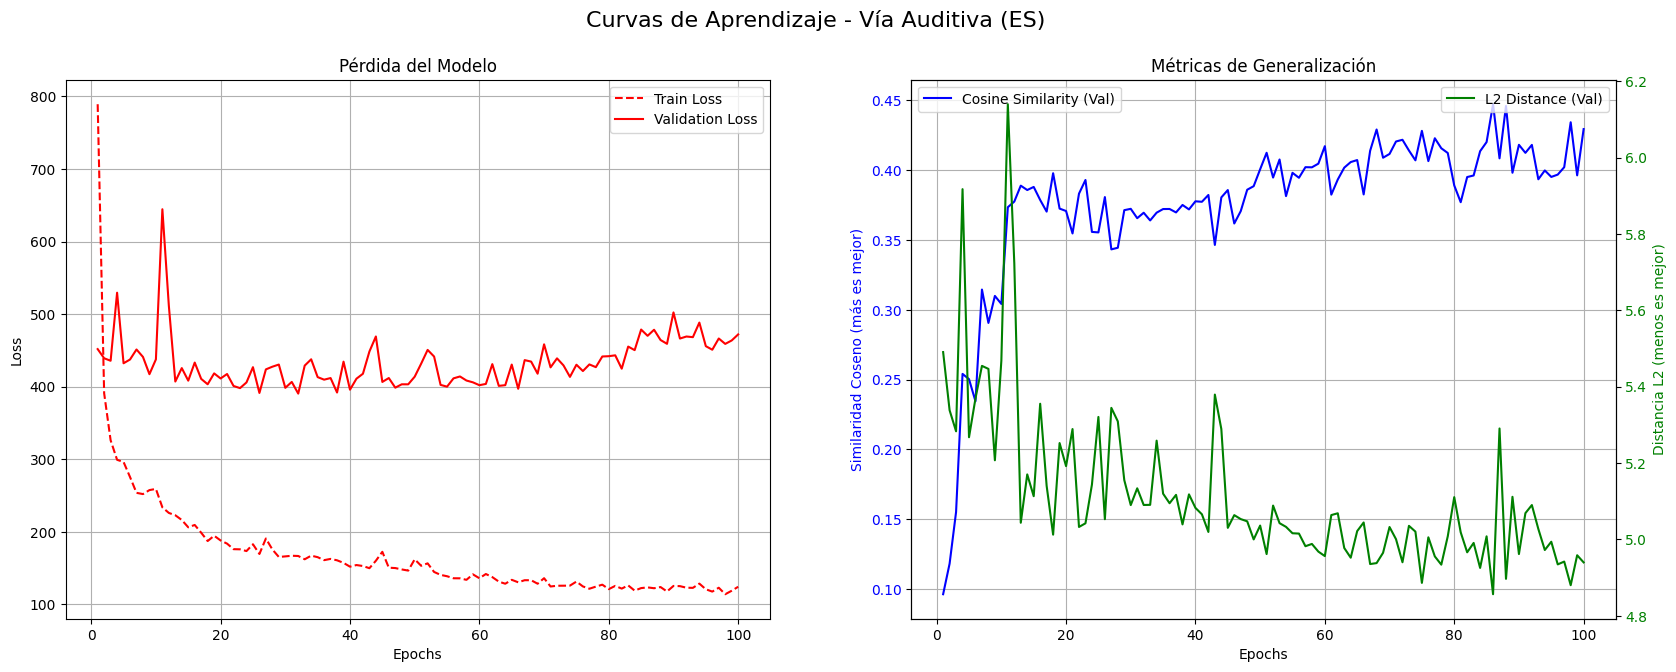


Evaluando el rendimiento sobre los datos de entrenamiento...


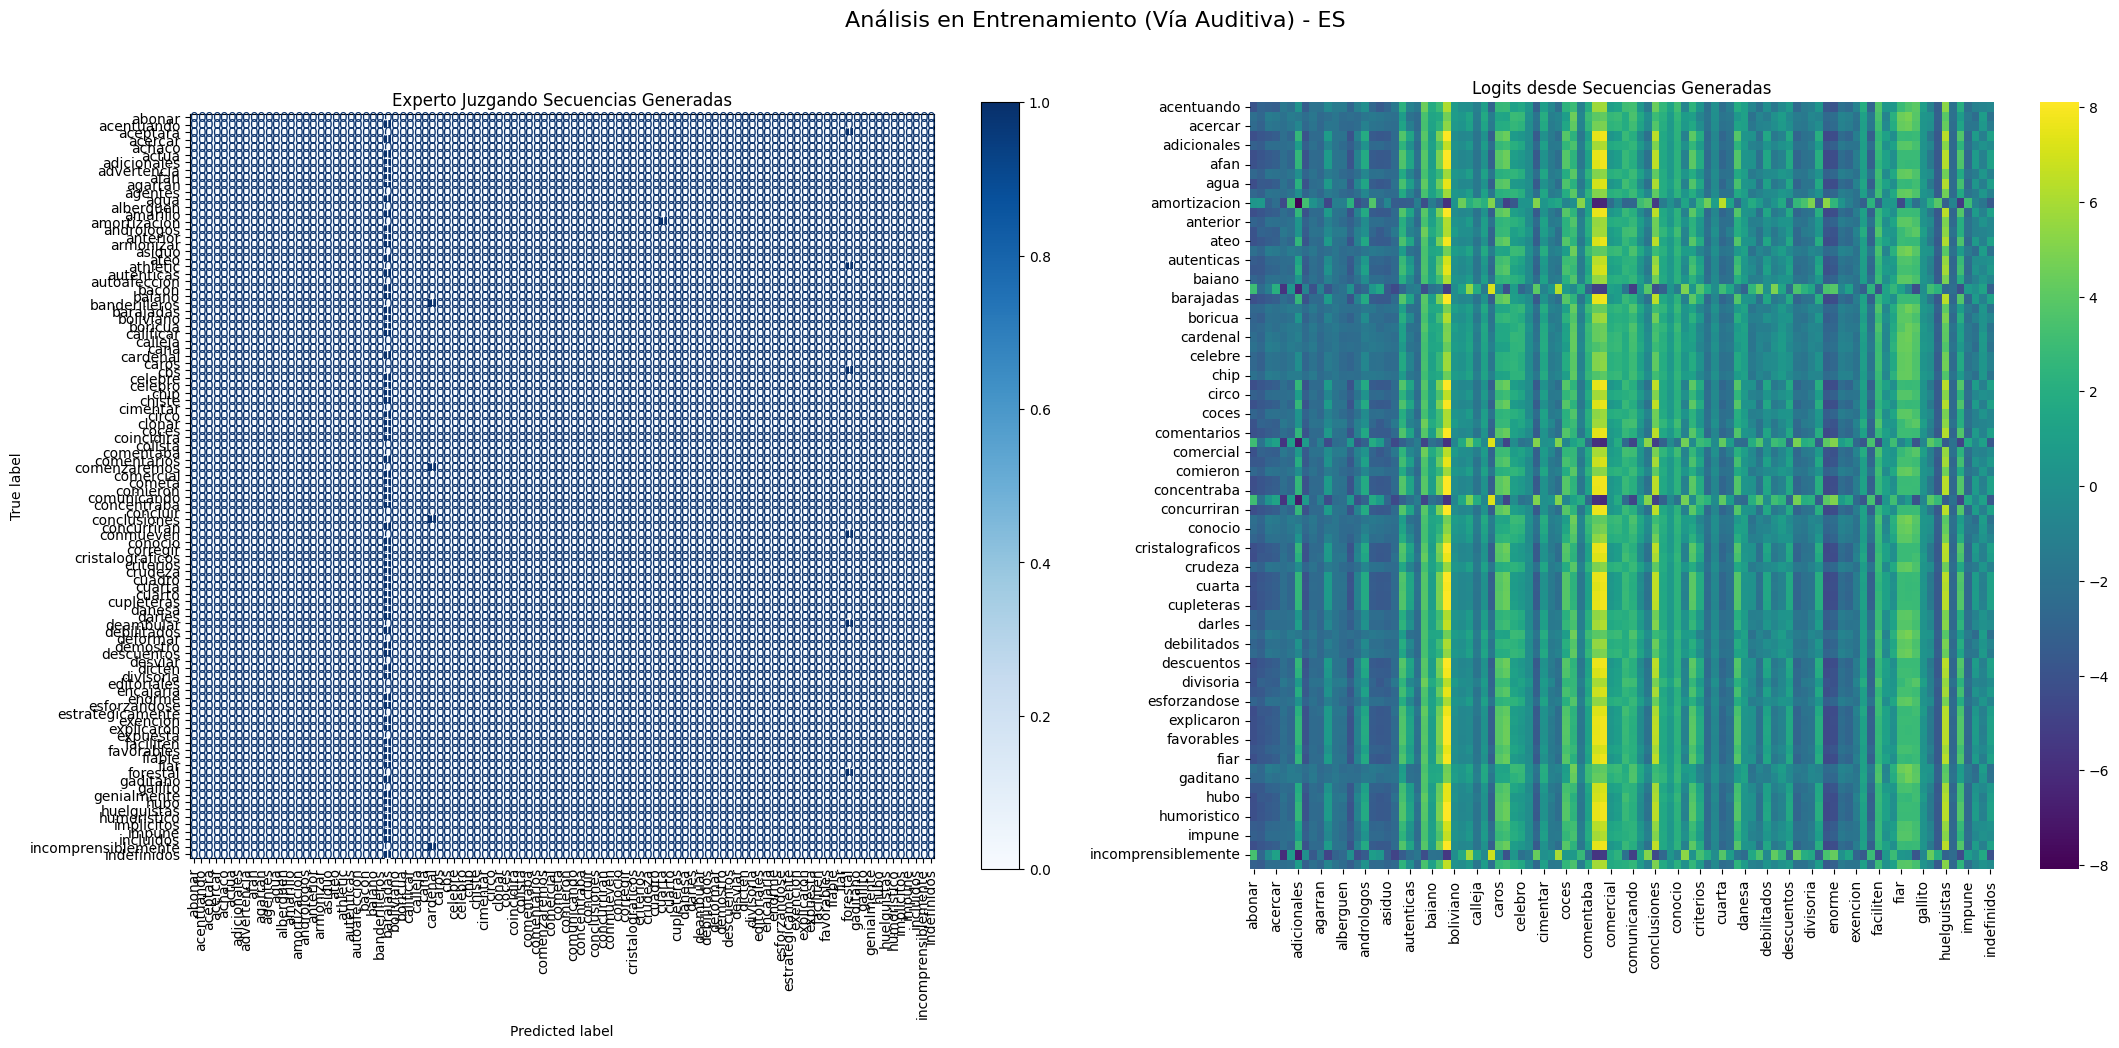


Evaluando la generalización sobre datos no vistos...
Calculando proyección t-SNE...


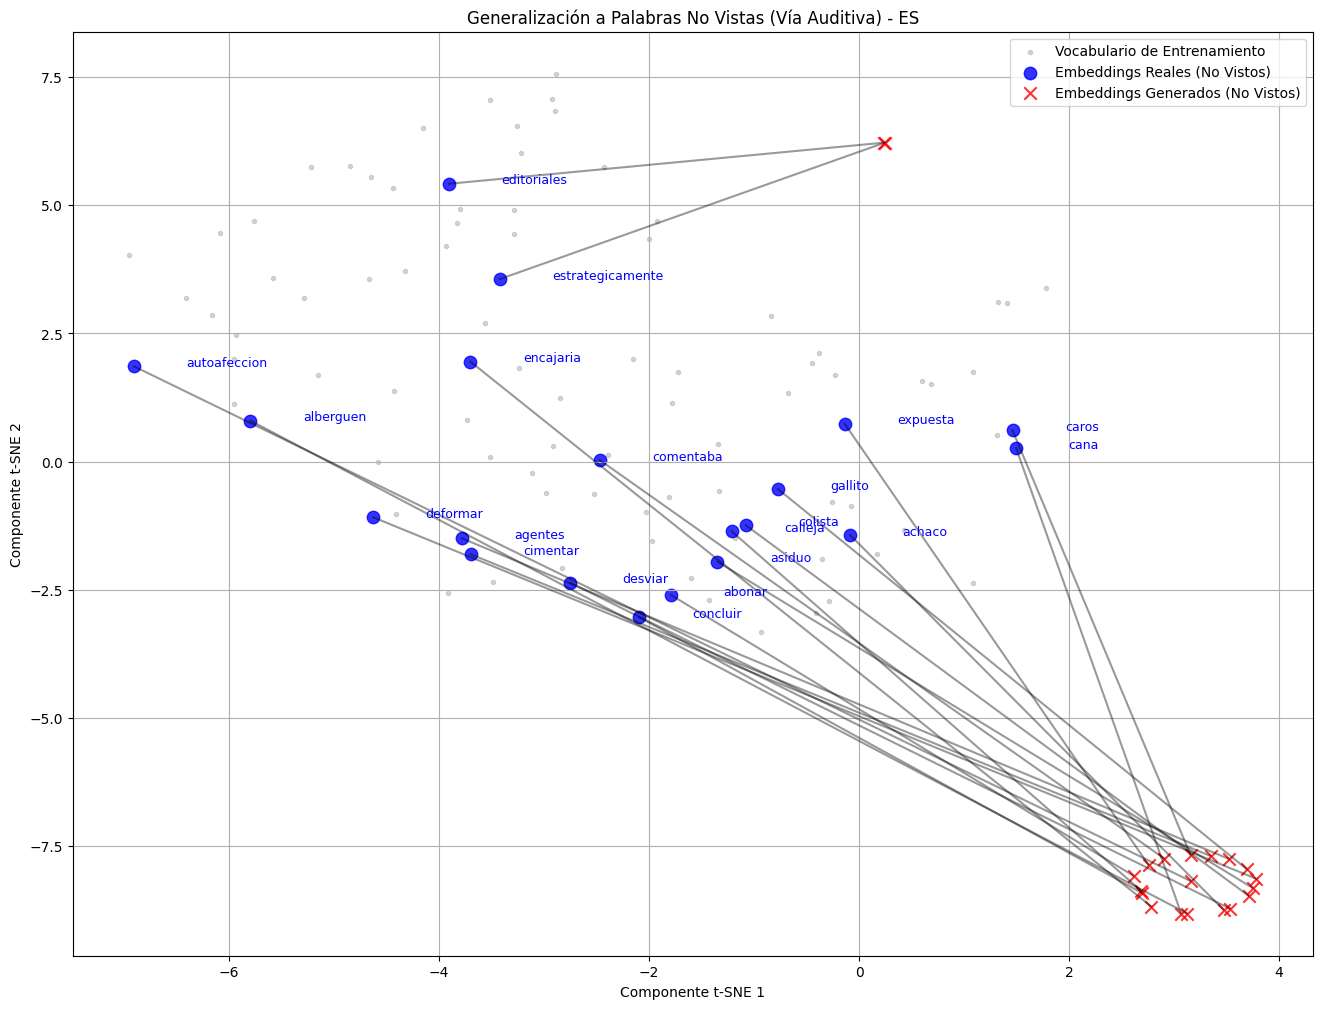

Modelo de la Vía Auditiva para 'es' guardado en: /home/daniel/Proyectos/phonological-awareness/results/trained_models/es_auditory_pathway_final.pth

--- Generando Artefactos para la Vía Auditiva de: EN ---


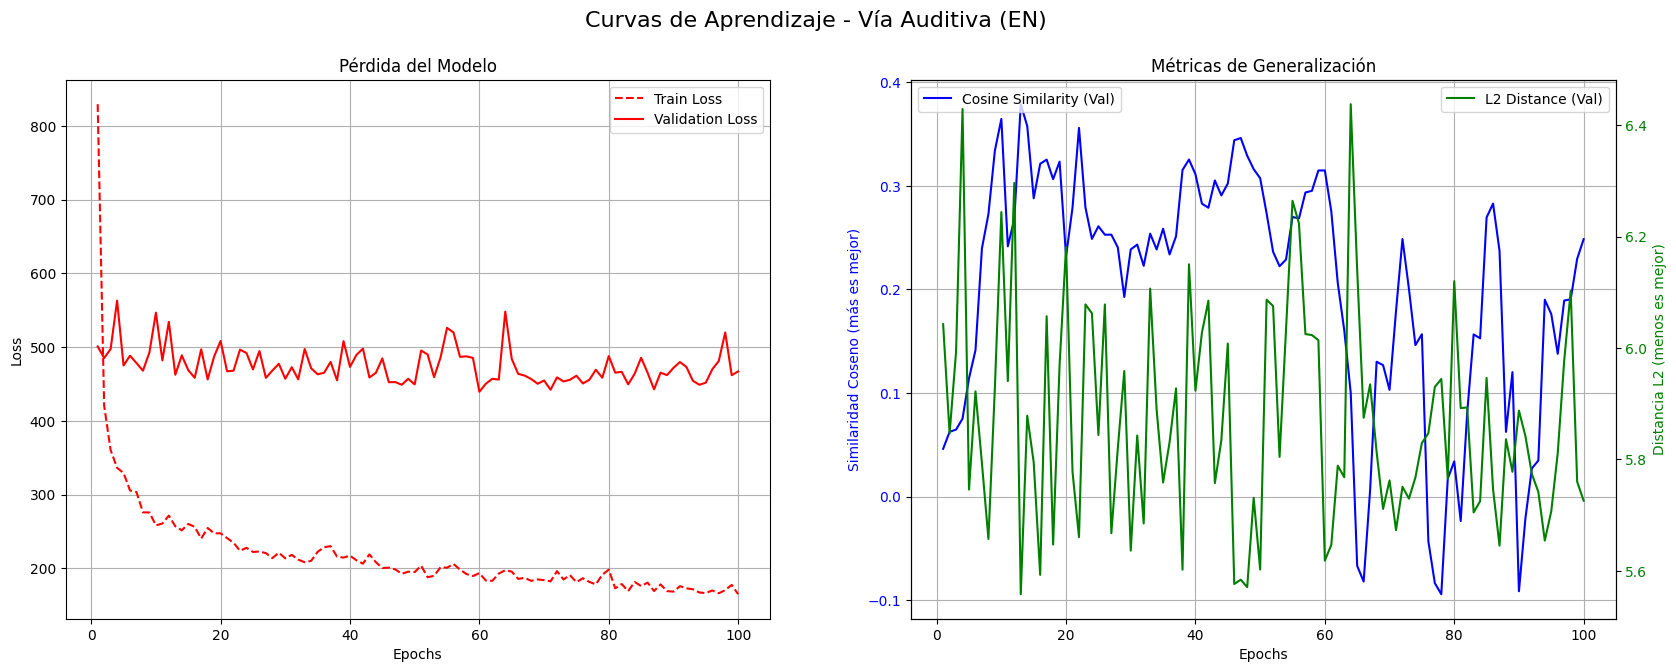


Evaluando el rendimiento sobre los datos de entrenamiento...


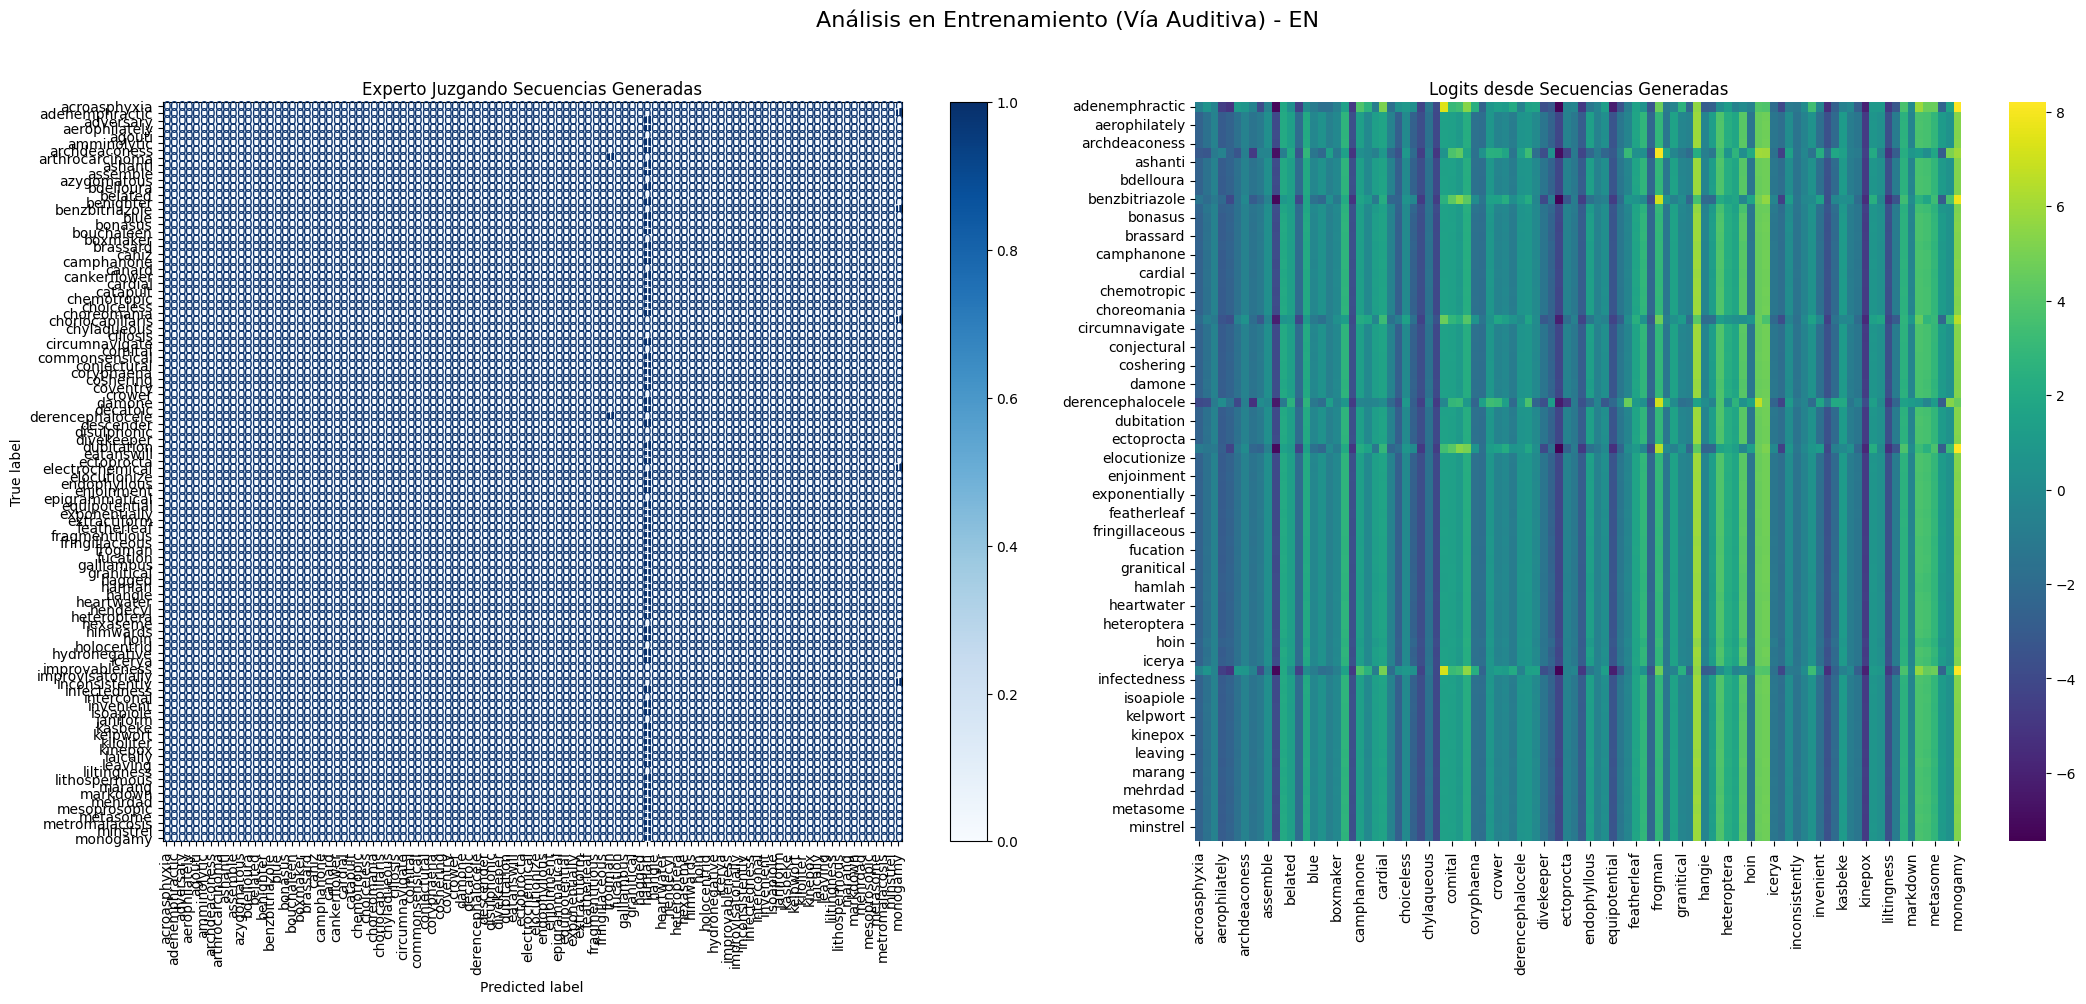


Evaluando la generalización sobre datos no vistos...
Calculando proyección t-SNE...


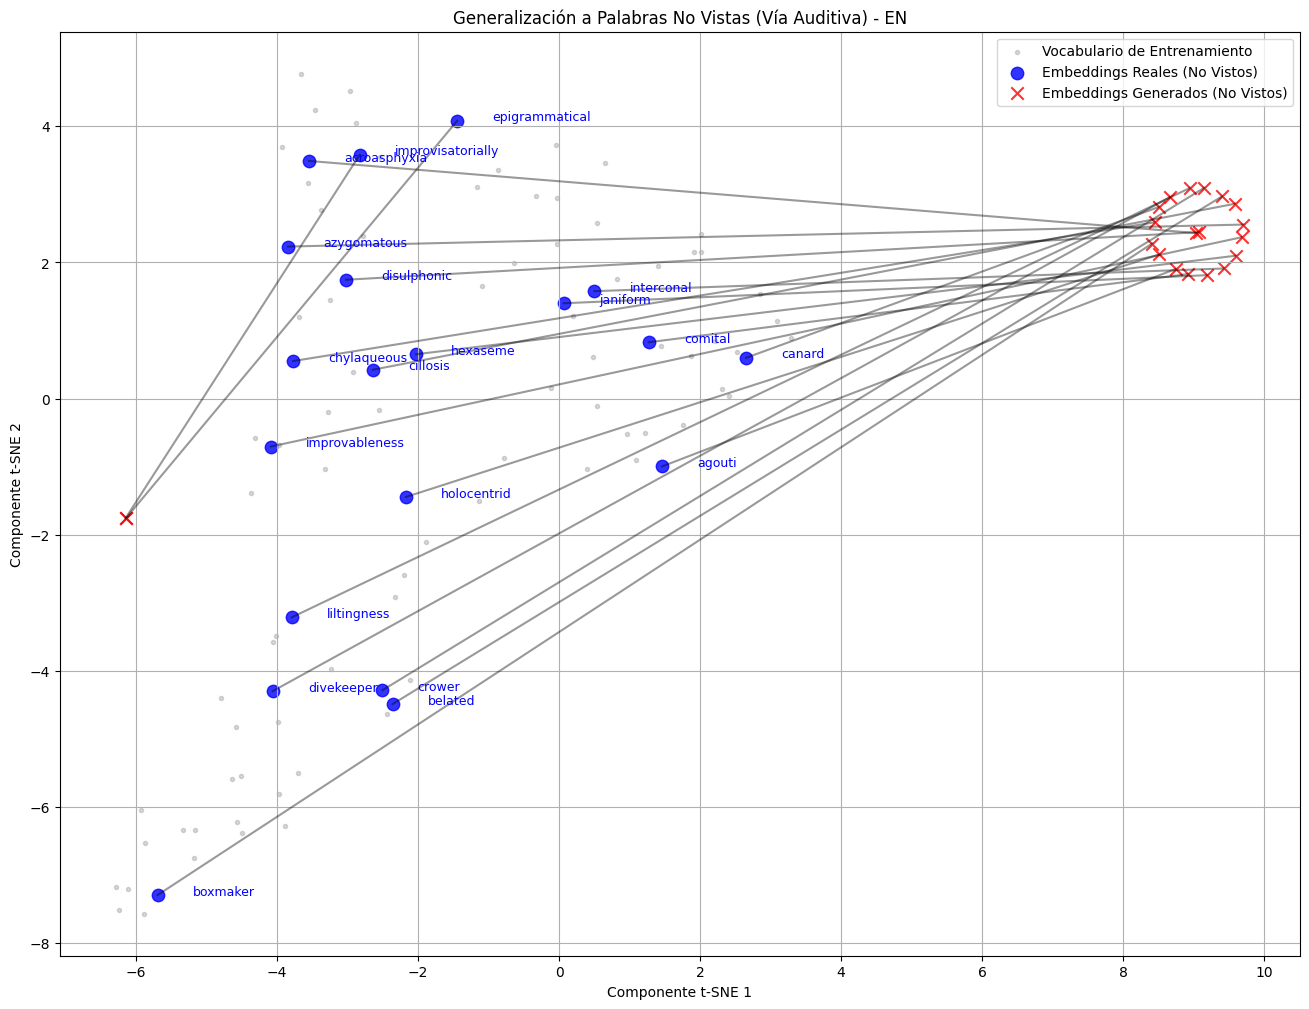

Modelo de la Vía Auditiva para 'en' guardado en: /home/daniel/Proyectos/phonological-awareness/results/trained_models/en_auditory_pathway_final.pth


In [5]:
# ===================================================================
# Celda 6: Bucle Final de Evaluación y Visualización
# ===================================================================
def plot_generative_learning_curves(history, title, file_path):
    """Genera y guarda las curvas de aprendizaje para el modelo generativo."""
    epochs = range(1, len(history['train_loss']) + 1)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))
    fig.suptitle(title, fontsize=16)

    # Gráfico de Pérdida
    ax1.plot(epochs, history['train_loss'], 'r--', label='Train Loss')
    ax1.plot(epochs, history['val_loss'], 'r-', label='Validation Loss')
    ax1.set_title('Pérdida del Modelo'); ax1.set_xlabel('Epochs'); ax1.set_ylabel('Loss'); ax1.legend(); ax1.grid(True)

    # Gráfico de Métricas de Generalización
    ax2.plot(epochs, history['val_cosine_sim'], 'b-', label='Cosine Similarity (Val)')
    ax2.set_ylabel('Similaridad Coseno (más es mejor)', color='b'); ax2.tick_params(axis='y', labelcolor='b'); ax2.legend(loc='upper left')
    ax2_twin = ax2.twinx()
    ax2_twin.plot(epochs, history['val_l2_dist'], 'g-', label='L2 Distance (Val)')
    ax2_twin.set_ylabel('Distancia L2 (menos es mejor)', color='g'); ax2_twin.tick_params(axis='y', labelcolor='g'); ax2_twin.legend(loc='upper right')
    ax2.set_title('Métricas de Generalización'); ax2.set_xlabel('Epochs'); ax2.grid(True)
    
    plt.savefig(file_path); plt.show()

for lang, res in results_auditory.items():
    print(f"\n--- Generando Artefactos para la Vía Auditiva de: {lang.upper()} ---")
    auditory_model = res['auditory_model']; word_expert = res['word_expert']; history = res['history']
    train_dataset = res['train_dataset']; val_dataset = res['val_dataset']; original_label_map = res['original_label_map']
    
    # --- 1. Visualizar Curvas de Aprendizaje (con nuevas métricas) ---
    plot_generative_learning_curves(history, f"Curvas de Aprendizaje - Vía Auditiva ({lang.upper()})", figure_dir / f"{lang}_{MODEL_ARCHITECTURE}_learning_curves.png")
    
    # --- 2. Evaluación en el set de Entrenamiento ---
    print("\nEvaluando el rendimiento sobre los datos de entrenamiento...")
    train_loader_eval = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn_seq2seq)
    y_true_mapped, y_pred_transformer, logits_transformer = [], [], []
    heatmap_row_labels = []
    auditory_model.eval(); word_expert.eval()
    with torch.no_grad():
        for batch in train_loader_eval:
            if batch[0] is None: continue
            padded_phonemes, padded_words, word_lengths, labels, words = batch
            phoneme_padding_mask = (padded_phonemes.sum(dim=2) == 0).to(device)
            generated_seq = auditory_model(padded_phonemes.to(device), phoneme_padding_mask, padded_words.to(device), teacher_forcing_ratio=0.0)
            transformer_logits_out = word_expert(generated_seq, word_lengths)
            y_pred_transformer.extend(transformer_logits_out.argmax(1).cpu().numpy()); logits_transformer.append(transformer_logits_out.cpu())
            true_indices_mapped = [original_label_map.get(word, -1) for word in words]; y_true_mapped.extend(true_indices_mapped)
            heatmap_row_labels.extend(words)
    fig, axes = plt.subplots(1, 2, figsize=(22, 10)); fig.suptitle(f'Análisis en Entrenamiento (Vía Auditiva) - {lang.upper()}', fontsize=16)
    original_tick_labels = [text for text, index in sorted(original_label_map.items(), key=lambda item: item[1])]
    cm = confusion_matrix(y_true_mapped, y_pred_transformer, labels=range(len(original_tick_labels)))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=original_tick_labels)
    axes[0].set_title("Experto Juzgando Secuencias Generadas"); disp.plot(ax=axes[0], xticks_rotation='vertical', cmap='Blues')
    logits_df = pd.DataFrame(torch.cat(logits_transformer).numpy(), index=heatmap_row_labels, columns=original_tick_labels).sort_index()
    axes[1].set_title("Logits desde Secuencias Generadas"); sns.heatmap(logits_df, ax=axes[1], cmap='viridis')
    plt.tight_layout(rect=[0, 0, 1, 0.96]); plt.savefig(figure_dir / f"{lang}_{MODEL_ARCHITECTURE}_training_evaluation.png"); plt.show()
    
    # --- 3. Evaluación de Generalización en el set de Validación (t-SNE) ---
    print("\nEvaluando la generalización sobre datos no vistos...")
    val_loader_eval = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn_seq2seq)
    val_real_embeds_mean, val_pred_embeds_mean, val_words = [], [], []
    with torch.no_grad():
        for batch in val_loader_eval:
            if batch[0] is None: continue
            padded_phonemes, padded_words, _, _, words = batch
            phoneme_padding_mask = (padded_phonemes.sum(dim=2) == 0).to(device)
            generated_seq = auditory_model(padded_phonemes.to(device), phoneme_padding_mask, padded_words.to(device), teacher_forcing_ratio=0.0)
            val_real_embeds_mean.append(padded_words.mean(dim=1)); val_pred_embeds_mean.append(generated_seq.mean(dim=1).cpu()); val_words.extend(words)
    train_embeds_mean = []
    with torch.no_grad():
        for batch in train_loader_eval:
            if batch[0] is None: continue
            _, padded_words, _, _, _ = batch
            train_embeds_mean.append(padded_words.mean(dim=1))
    if val_real_embeds_mean:
        train_embeds_mean=torch.cat(train_embeds_mean).numpy(); val_real_embeds_mean=torch.cat(val_real_embeds_mean).numpy(); val_pred_embeds_mean=torch.cat(val_pred_embeds_mean).numpy()
        combined_embeds = np.vstack([train_embeds_mean, val_real_embeds_mean, val_pred_embeds_mean])
        print("Calculando proyección t-SNE..."); tsne = TSNE(n_components=2, random_state=RANDOM_SEED, perplexity=min(30, len(combined_embeds)-1))
        tsne_results = tsne.fit_transform(combined_embeds)
        offset=0; tsne_train=tsne_results[offset:offset+len(train_embeds_mean)]; offset+=len(train_embeds_mean); tsne_val_real=tsne_results[offset:offset+len(val_real_embeds_mean)]; offset+=len(val_real_embeds_mean); tsne_val_pred=tsne_results[offset:offset+len(val_pred_embeds_mean)]
        plt.figure(figsize=(16, 12)); plt.scatter(tsne_train[:, 0], tsne_train[:, 1], c='gray', marker='.', alpha=0.3, label='Vocabulario de Entrenamiento')
        plt.scatter(tsne_val_real[:, 0], tsne_val_real[:, 1], c='blue', marker='o', s=80, alpha=0.8, label='Embeddings Reales (No Vistos)')
        plt.scatter(tsne_val_pred[:, 0], tsne_val_pred[:, 1], c='red', marker='x', s=80, alpha=0.8, label='Embeddings Generados (No Vistos)')
        for i, word in enumerate(val_words):
            plt.plot([tsne_val_real[i, 0], tsne_val_pred[i, 0]], [tsne_val_real[i, 1], tsne_val_pred[i, 1]], 'k-', alpha=0.4)
            plt.text(tsne_val_real[i, 0]+0.5, tsne_val_real[i, 1], word, fontsize=9, color='blue')
        plt.title(f'Generalización a Palabras No Vistas (Vía Auditiva) - {lang.upper()}'); plt.xlabel('Componente t-SNE 1'); plt.ylabel('Componente t-SNE 2')
        plt.legend(); plt.grid(True); plt.savefig(figure_dir / f"{lang}_{MODEL_ARCHITECTURE}_tsne_generalization.png"); plt.show()

    # --- 4. Guardado Final del Modelo ---
    model_path = model_dir / f"{lang}_{MODEL_ARCHITECTURE}.pth"
    torch.save(auditory_model.state_dict(), model_path)
    print(f"Modelo de la Vía Auditiva para '{lang}' guardado en: {model_path}")